# Stage II length binned gradient boosting classifier

With the stage two dataset complete, all that remains is to construct a second set of classifiers.

## 1. Run setup

In [1]:
# Change working directory to parent so we can import as we would from main.py
print(f'Working directory: ', end = '')
%cd ..

import h5py
import pickle
import pandas as pd

from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer

import configuration as config
import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs
import functions.length_binned_xgboost as xgb_funcs

Working directory: /mnt/arkk/llm_detector/classifier


Set some run parameters and filepaths:

In [2]:
# Data to work with
dataset_name = 'falcon-7b_scores_v2_10-300_words_stage_I'

# H5py dataset path
input_file = f'{config.DATA_PATH}/{dataset_name}_stage_II.h5'

# Number of folds to run for cross validation
cv_folds = 7

# Number of parameter sets to sample for hyperparameter optimization
hyperparameter_iterations = 100

# Paths to save and load results
cross_validation_results_filename = f'{config.DATA_PATH}/stage_two_cross_validation_results_{cv_folds}_folds.pkl'
hyperparameter_optimization_results_filename = f'{config.DATA_PATH}/stage_two_hyperparameter_optimization_results_{hyperparameter_iterations}_iterations.pkl'

# Dictionary to hold testing/experimentation results
parsed_results = {
    'Fold': [],
    'Condition': [],
    'Optimized': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Make evaluation metrics scorers
scoring_funcs = {
    'negated_binary_cross_entropy': make_scorer(helper_funcs.negated_binary_cross_entropy),
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

# Plots to draw
plots = ['Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

OK, I think we are ready, let's do the cross-validation.

## 2. Stage II classifiers: baseline performance
### 2.1. Cross-validation

Cross-validating bin_026_050
Cross-validating bin_051_075
Cross-validating bin_076_100
Cross-validating bin_101_125
Cross-validating bin_126_150
Cross-validating bin_151_175
Cross-validating bin_176_200
Cross-validating bin_201_225
Cross-validating bin_226_250
Cross-validating bin_251_275


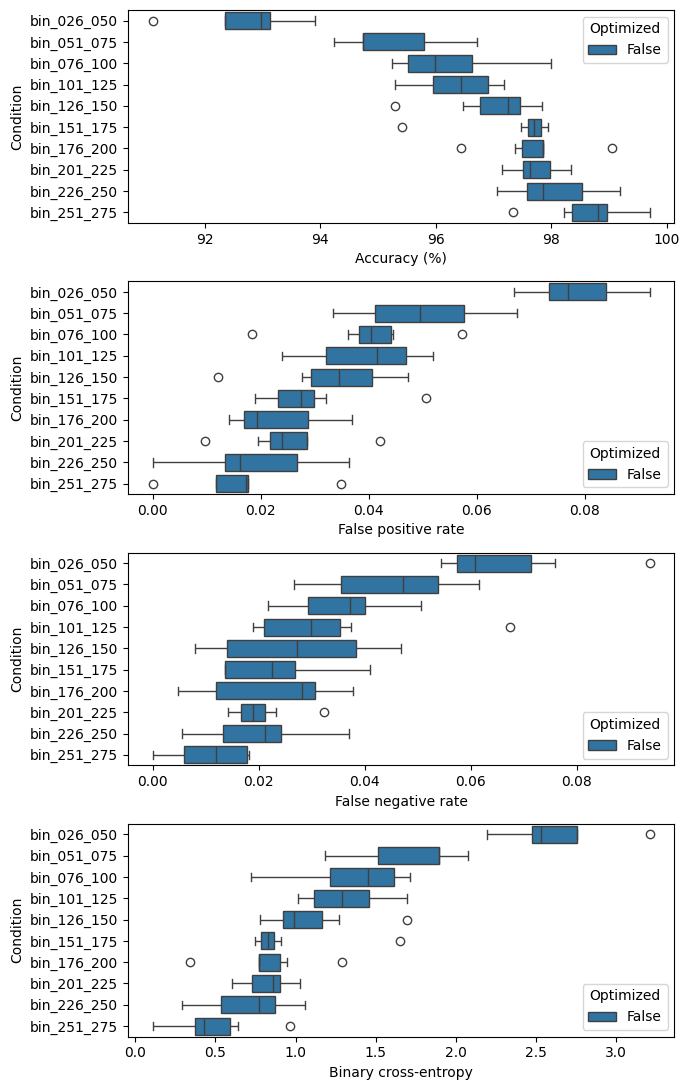

CPU times: user 3.02 s, sys: 1.62 s, total: 4.64 s
Wall time: 10.8 s


In [3]:
%%time

# Do the cross-validation
parsed_results = xgb_funcs.cross_validate_bins(
    input_file = input_file,
    parsed_results = parsed_results,
    scoring_funcs = scoring_funcs,
    cv_folds = cv_folds,
    shuffle_control = False
)

# Save the result
with open(cross_validation_results_filename, 'wb') as result_output_file:
    pickle.dump(parsed_results, result_output_file, protocol = pickle.HIGHEST_PROTOCOL)

# Plot the results
plot_funcs.plot_two_factor_cross_validation(plots, parsed_results).show()

### 2.2. Cross-validation: shuffled control

Cross-validating bin_026_050
Cross-validating bin_051_075
Cross-validating bin_076_100
Cross-validating bin_101_125
Cross-validating bin_126_150
Cross-validating bin_151_175
Cross-validating bin_176_200
Cross-validating bin_201_225
Cross-validating bin_226_250
Cross-validating bin_251_275


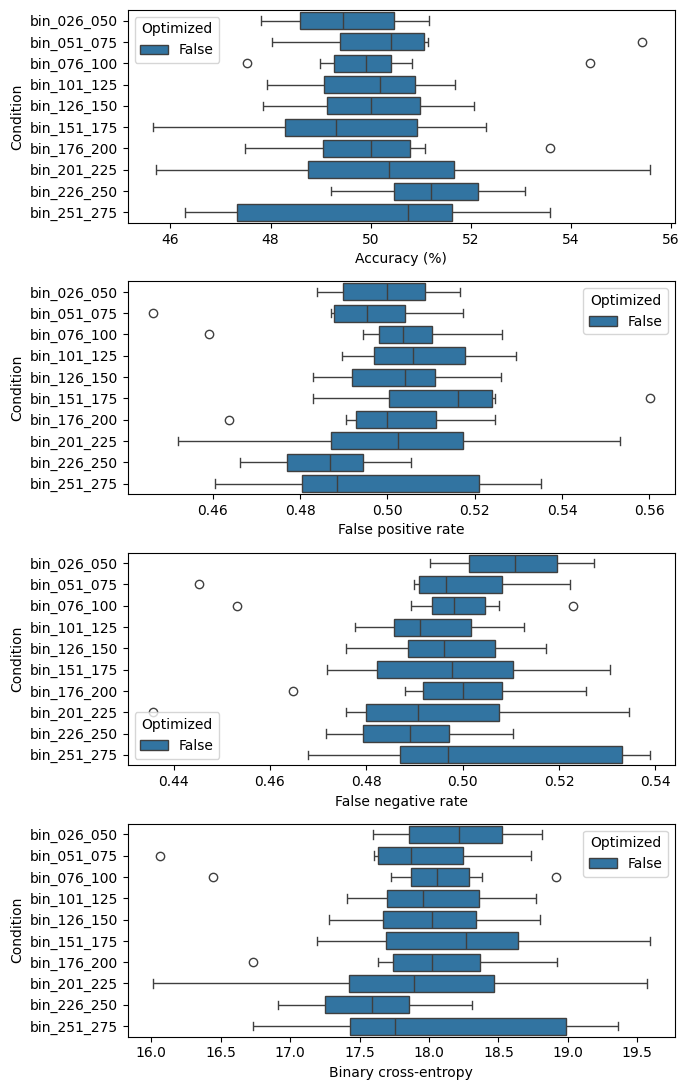

CPU times: user 2.25 s, sys: 375 ms, total: 2.62 s
Wall time: 4.73 s


In [4]:
%%time

# Start a fresh results dictionary so we don't over-write our baseline results
parsed_control_results = {
    'Fold': [],
    'Condition': [],
    'Optimized': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Do the cross-validation
parsed_control_results = xgb_funcs.cross_validate_bins(
    input_file = input_file,
    parsed_results = parsed_control_results,
    scoring_funcs = scoring_funcs,
    cv_folds = cv_folds,
    shuffle_control = True
)

# Plot the results
plot_funcs.plot_two_factor_cross_validation(plots, parsed_control_results).show()

## 3. Stage II classifiers: hyperparameter tuning
### 3.1. Random search with cross-validation

In [5]:
# Define hyperparameter distributions for randomized grid search
parameter_distributions = {
    'learning_rate': uniform(loc = 0.0001, scale = 0.9999),
    'gamma': uniform(loc = 0.0, scale = 100.0),
    'max_depth': randint(1, 100),
    'min_child_weight': uniform(loc = 0.0001, scale = 0.9999),
    'subsample': uniform(loc = 0.5, scale = 0.5),
    'reg_alpha': uniform(loc = 0.0, scale = 1.0),
    'reg_lambda': uniform(loc = 0.0, scale = 1.0),
    'n_estimators': randint(1, 100),
    'num_parallel_tree': randint(1, 50)
}

In [6]:
%%time

# Do the optimization
results = xgb_funcs.hyperparameter_optimize_bins(
    input_file = input_file,
    parameter_distributions = parameter_distributions,
    scoring_funcs = scoring_funcs,
    cv_folds = cv_folds,
    hyperparameter_iterations = hyperparameter_iterations
)

# Save the raw result
with open(hyperparameter_optimization_results_filename, 'wb') as result_output_file:
    pickle.dump(results, result_output_file, protocol = pickle.HIGHEST_PROTOCOL)

Optimizing bin_026_050
Optimizing bin_051_075
Optimizing bin_076_100
Optimizing bin_101_125
Optimizing bin_126_150
Optimizing bin_151_175
Optimizing bin_176_200
Optimizing bin_201_225
Optimizing bin_226_250
Optimizing bin_251_275
CPU times: user 1min 41s, sys: 1.8 s, total: 1min 43s
Wall time: 4min 42s


### 3.2. Hyperparameter optimization results

In [7]:
# Parse the results
winners, cv_results = xgb_funcs.parse_hyperparameter_tuning_results(results)

# Save the winning models to disk
output_filename=f'{config.MODELS_PATH}/stage_II_classifiers.pkl'

with open(output_filename, 'wb') as output_file:
    pickle.dump(winners, output_file)

bin_026_050 best score: -2.363306321260332
bin_051_075 best score: -1.5251002371937346
bin_076_100 best score: -1.2700441868804562
bin_101_125 best score: -1.0938624442399882
bin_126_150 best score: -0.928559685972109
bin_151_175 best score: -0.8503089921416891
bin_176_200 best score: -0.7606601863498115
bin_201_225 best score: -0.72245140088436
bin_226_250 best score: -0.60688300323791
bin_251_275 best score: -0.4279997397232115


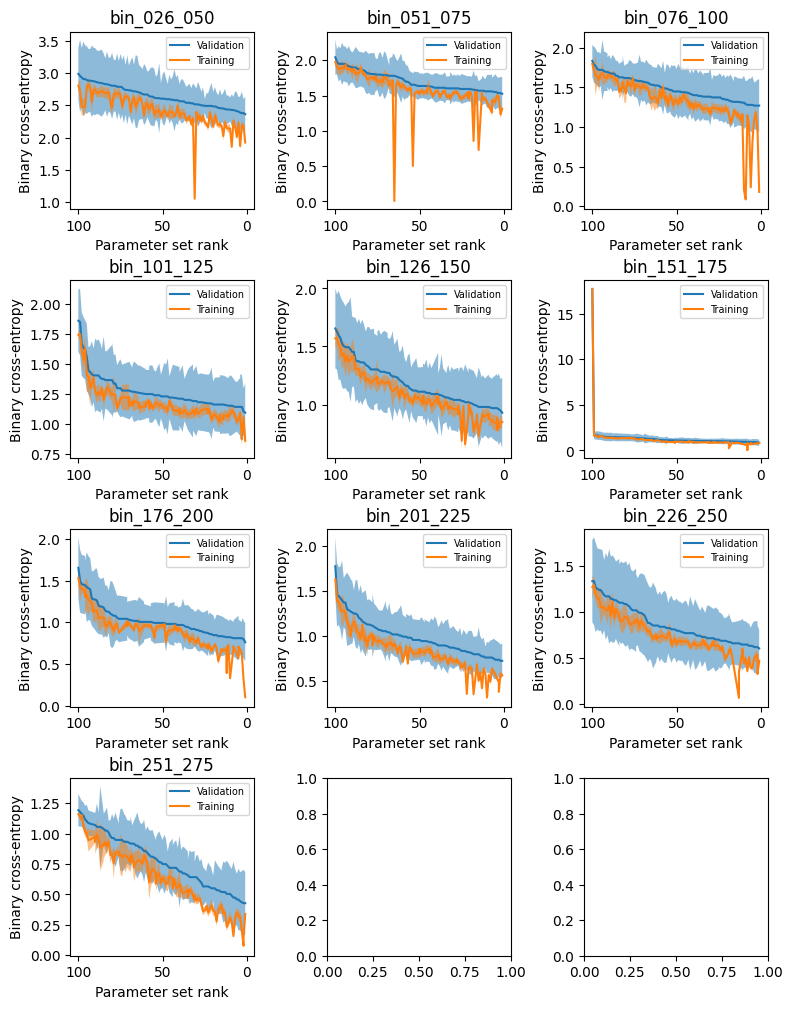

In [8]:
# Plot the results
plot_funcs.plot_hyperparameter_tuning(cv_results).show()

### 3.3. Winning models comparison to baseline

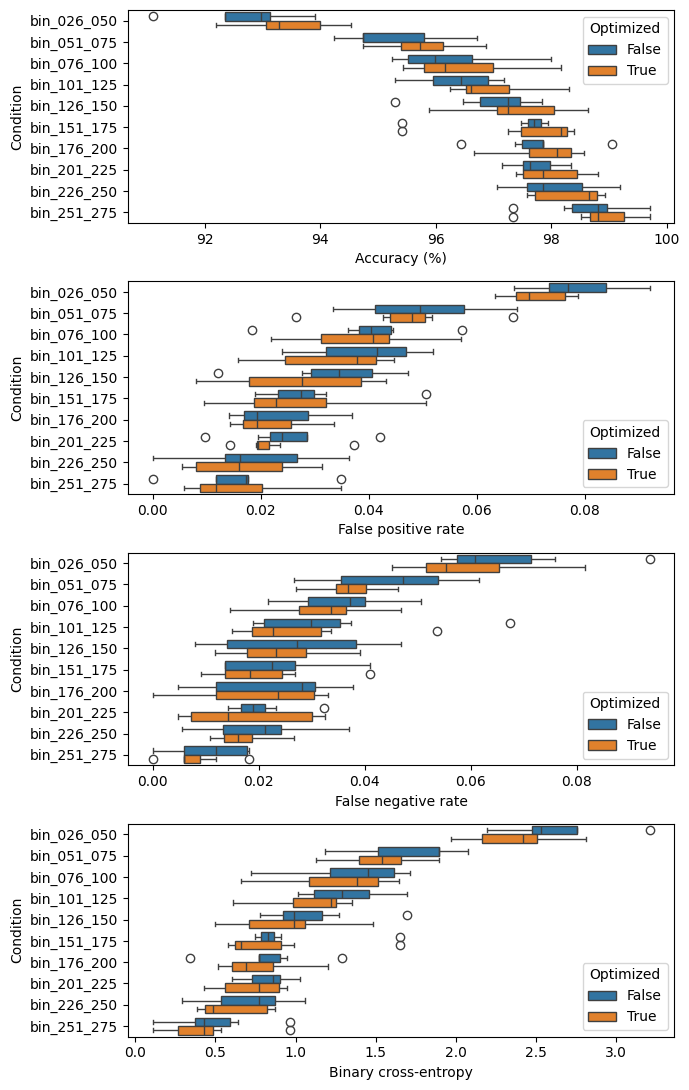

In [9]:
# Go through the hyperparameter optimization results, format and 
# add them to the results from the baseline cross-validation
parsed_results = xgb_funcs.add_winners_to_parsed_results(
    cv_results, 
    parsed_results, 
    cv_folds
)

plot_funcs.plot_two_factor_cross_validation(plots, parsed_results).show()

### 3.4. Winning models evaluation on hold-out test data

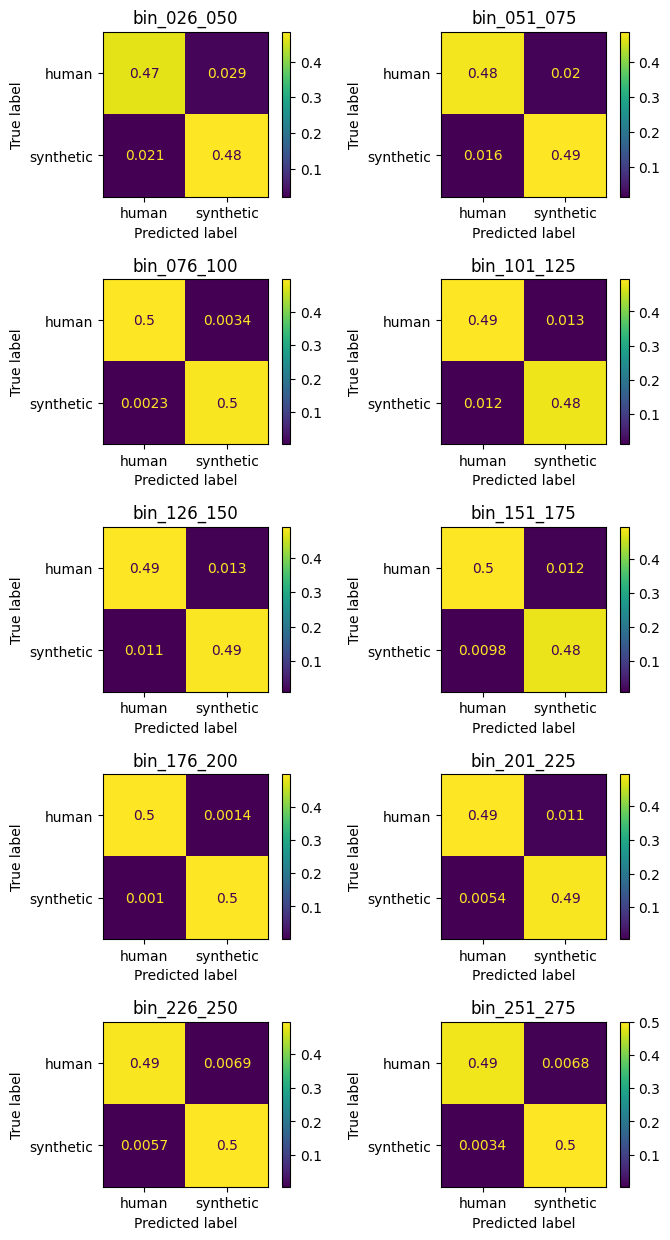

In [10]:
# Plot confusion matrix for hold-out test data in each bin
plot_funcs.plot_testing_confusion_matrices(winners, input_file).show()